In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import os
# from dotenv import load_dotenv
import time
from collections import Counter
import random
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,precision_score,recall_score, roc_auc_score, precision_recall_curve, fbeta_score, roc_curve, log_loss
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPooling2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing import image as IMG
from tensorflow.keras.models import load_model

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, matutils

import holoviews as hv
import hvplot
from hvplot import pandas
from bokeh.models import NumeralTickFormatter

from sklearn.model_selection import train_test_split

%pylab inline

2022-08-06 17:26:25.712755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 17:26:25.712790: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Populating the interactive namespace from numpy and matplotlib


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Dataset A - All Publishers

**Images: Non-Neural Net Baseline-Model**

In [ ]:
# (X_train, X_test,y_train,y_test)
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)

In [ ]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

In [ ]:
X_train_df = pd.DataFrame(X_train.reshape([5707,-1]))
X_test_df = pd.DataFrame(X_test.reshape([1902,-1]))
X_val_df = pd.DataFrame(X_val.reshape([1902,-1]))

X_train_df = pd.concat([X_train_df, X_val_df], axis=0)
X_train_df.reset_index(inplace=True, drop=True)

y_train_df = pd.concat([y_train, y_val], axis=0)
y_train_df.reset_index(inplace=True, drop=True)

In [ ]:
# Create checkpoint
y_train_df.to_csv('y_train_df_base_allpublishers.csv')
y_test.to_csv('y_test_df_base_allpublishers.csv')

In [2]:
# Load checkpoint
# X_train_df = pd.read_csv('X_train_df_base_allpublishers.csv')
y_train_df = pd.read_csv('y_train_df_base_allpublishers.csv')
y_train_df = y_train_df.drop(['Unnamed: 0'], axis=1).iloc[:,0]
y_train_df.rename('Publishers',inplace=True)

y_test = pd.read_csv('y_test_df_base_allpublishers.csv')
y_test = y_test.drop(['Unnamed: 0'], axis=1).iloc[:,0]

In [ ]:
scaler = StandardScaler()
X_train_df_scaled = scaler.fit_transform(X_train_df)
X_test_df_scaled = scaler.transform(X_test_df)

In [ ]:
# Create checkpoint
with open('X_train_nonNN_model_scaled.pickle','wb') as file:
    pickle.dump(X_train_df_scaled,file)

with open('X_test_nonNN_model_scaled.pickle','wb') as file:
    pickle.dump(X_test_df_scaled,file)

In [3]:
# Load checkpoint
with open('X_train_nonNN_model_scaled.pickle','rb') as file:
    X_train_df_scaled = pickle.load(file)
    
with open('X_test_nonNN_model_scaled.pickle','rb') as file:
    X_test_df_scaled = pickle.load(file)

In [4]:
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train_df_scaled)
X_test_2PC = pca.transform(X_test_df_scaled)

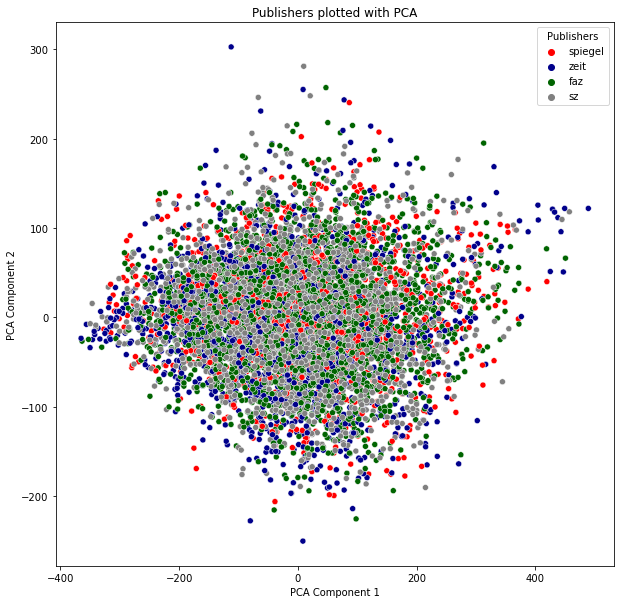

In [5]:
figsize(10, 10)

sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1],
                hue=y_train_df.replace({1: 'spiegel', 3:'zeit', 0:'faz', 2:'sz'}), alpha=1,
                palette=['red', 'darkblue', 'darkgreen', 'grey'])
xlabel("PCA Component 1")
ylabel("PCA Component 2")
title("Publishers plotted with PCA");

In [6]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train_df)
lr.score(X_test_2PC, y_test)

0.34752891692954785

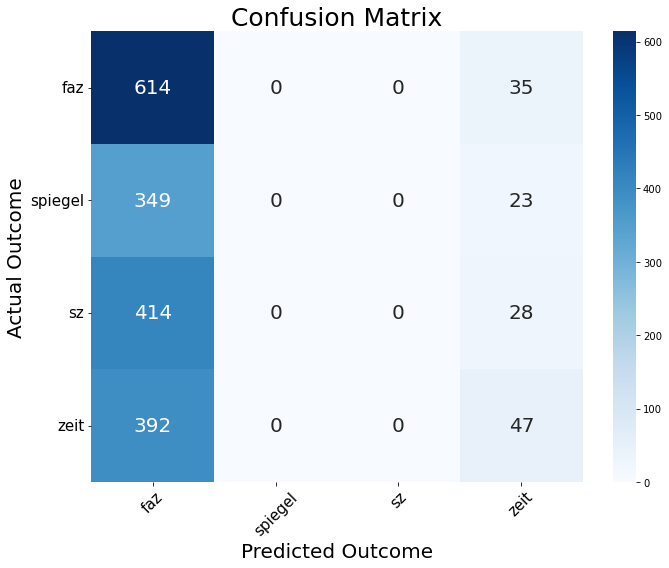

In [25]:
y_pred= lr.predict(X_test_2PC)

plt.figure(figsize=(10,8))
#plt.subplot(131)
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Images: Neural Net Baseline-Model**

In [2]:
# (X_train, X_test,y_train,y_test)
with open('image_data_array.pickle','rb') as file:
    data = pickle.load(file)

In [3]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

In [5]:
X_train.shape

(5707, 150, 150, 3)

In [13]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)

In [14]:
train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=32)
test_ds = IMGgen.flow(X_test, y_test, batch_size=32)

In [16]:
if os.path.exists("cnn_model.h5") == False:
    ### basic CNN model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=X_train.shape[1:]))

    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(4, activation='softmax'))  # 4 target classes
     

    cnn.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        #loss ='categorical_crossentropy',
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        #optimizer = optimizer,
        optimizer = 'Adam',
        metrics=['accuracy'],
    )
    cnn.summary()
    
    cnn_result = cnn.fit(train_ds,
             validation_data= val_ds,
             epochs= 200, verbose= 1, batch_size = 32,
             callbacks = tf.keras.callbacks.EarlyStopping(patience= 5))  # track progress as we fit

    cnn.save("model_h5_file/cnn_model.h5")
    
    with open('cnn_result.pickle','wb')as file:
        pickle.dump(cnn_result, file)

else: 
    cnn = keras.models.load_model('model_h5_file/cnn_model.h5')
    
    with open('cnn_result.pickle','rb') as file:
        cnn_result = pickle.load(file)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

2022-07-31 18:16:21.306679: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89718784 exceeds 10% of free system memory.
2022-07-31 18:16:21.413087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42467328 exceeds 10% of free system memory.
2022-07-31 18:16:21.585581: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42467328 exceeds 10% of free system memory.
2022-07-31 18:16:21.770002: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44859392 exceeds 10% of free system memory.
2022-07-31 18:16:21.770103: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89718784 exceeds 10% of free system memory.


179/179 [==============================] - 86s 476ms/step - loss: 2.6967 - accuracy: 0.3049 - val_loss: 1.3710 - val_accuracy: 0.3412
Epoch 2/200
179/179 [==============================] - 84s 470ms/step - loss: 1.4255 - accuracy: 0.3180 - val_loss: 1.3606 - val_accuracy: 0.3396
Epoch 3/200
179/179 [==============================] - 86s 480ms/step - loss: 1.3974 - accuracy: 0.3277 - val_loss: 1.3613 - val_accuracy: 0.3412
Epoch 4/200
179/179 [==============================] - 86s 480ms/step - loss: 1.3891 - accuracy: 0.3396 - val_loss: 1.3629 - val_accuracy: 0.3412
Epoch 5/200
179/179 [==============================] - 86s 482ms/step - loss: 1.3877 - accuracy: 0.3380 - val_loss: 1.3617 - val_accuracy: 0.3412
Epoch 6/200
179/179 [==============================] - 88s 492ms/step - loss: 1.3848 - accuracy: 0.3391 - val_loss: 1.3583 - val_accuracy: 0.3412
Epoch 7/200
179/179 [==============================] - 88s 489ms/step - loss: 1.3810 - accuracy: 0.3396 - val_loss: 1.3613 - val_accurac

2022-07-31 19:12:13.357175: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e1526bf6-8896-4aa8-ba92-c873a8746278/assets


In [ ]:
#Load checkpoint
cnn = load_model('model_h5_file/cnn_model.h5')

with open('cnn_result.pickle','rb') as file:
        cnn_result = pickle.load(file)

In [17]:
y_pred= np.argmax(cnn.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.3732912723449001
recall : 0.30529876036068165
precision : 0.24368264663709283
f1 : 0.23884030559060476


/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


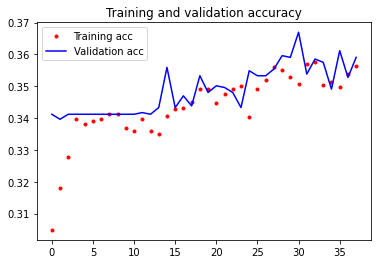

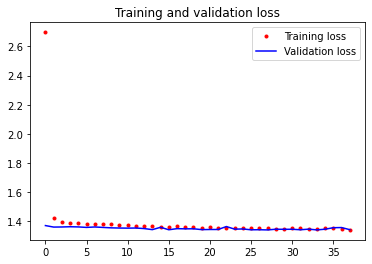

In [18]:
acc = cnn_result.history['accuracy']
val_acc = cnn_result.history['val_accuracy']
loss = cnn_result.history['loss']
val_loss = cnn_result.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r.', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
category_int_map = {'spiegel': 1, 'zeit': 3, 'faz': 0, 'sz': 2}
int_category_map = {1: 'spiegel', 3:'zeit', 0:'faz', 2:'sz'}

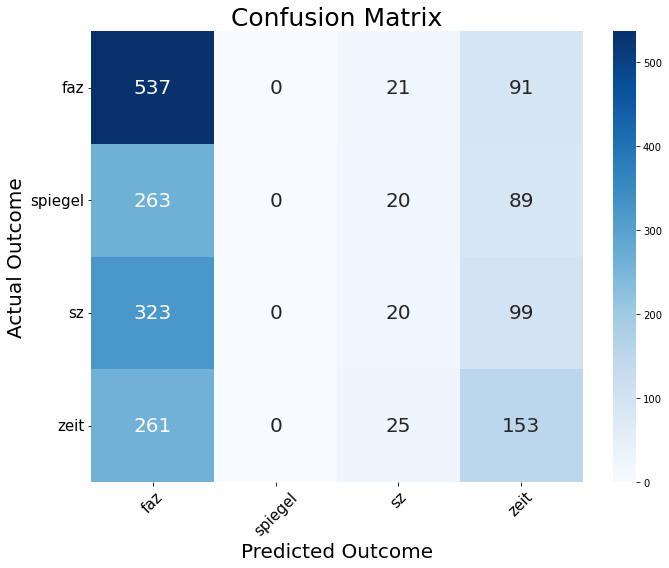

In [20]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

## Dataset B - Publishers FAZ (mid-right) and Spiegel (mid-left) (Binary classification)

**Images: Non-Neural Net Baseline-Model**

In [3]:
# (X_train, X_test,y_train,y_test)
with open('image_data_array_fazsp.pickle','rb') as file:
    data = pickle.load(file)

In [4]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

In [5]:
X_train_df = pd.DataFrame(X_train.reshape([3063,-1]))
X_test_df = pd.DataFrame(X_test.reshape([1021,-1]))
X_val_df = pd.DataFrame(X_val.reshape([1021,-1]))

X_train_df = pd.concat([X_train_df, X_val_df], axis=0)
X_train_df.reset_index(inplace=True, drop=True)

y_train_df = pd.concat([y_train, y_val], axis=0)
y_train_df.reset_index(inplace=True, drop=True)

In [6]:
# Create checkpoint
y_train_df.to_csv('y_train_df_base_fazsp.csv')
y_test.to_csv('y_test_df_base_fazsp.csv')

In [7]:
# Load checkpoint
# X_train_df = pd.read_csv('X_train_df_base_allpublishers.csv')
y_train_df = pd.read_csv('y_train_df_base_fazsp.csv')
y_train_df = y_train_df.drop(['Unnamed: 0'], axis=1).iloc[:,0]
y_train_df.rename('Publishers',inplace=True)

y_test = pd.read_csv('y_test_df_base_fazsp.csv')
y_test = y_test.drop(['Unnamed: 0'], axis=1).iloc[:,0]

In [8]:
scaler = StandardScaler()
X_train_df_scaled = scaler.fit_transform(X_train_df)
X_test_df_scaled = scaler.transform(X_test_df)

In [9]:
# Create checkpoint
with open('X_train_nonNN_model_scaled_fazsp.pickle','wb') as file:
    pickle.dump(X_train_df_scaled,file)

with open('X_test_nonNN_model_scaled_fazsp.pickle','wb') as file:
    pickle.dump(X_test_df_scaled,file)

In [ ]:
# Load checkpoint
with open('X_train_nonNN_model_scaled_fazsp.pickle','rb') as file:
    X_train_df_scaled = pickle.load(file)
    
with open('X_test_nonNN_model_scaled_fazsp.pickle','rb') as file:
    X_test_df_scaled = pickle.load(file)

In [10]:
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train_df_scaled)
X_test_2PC = pca.transform(X_test_df_scaled)

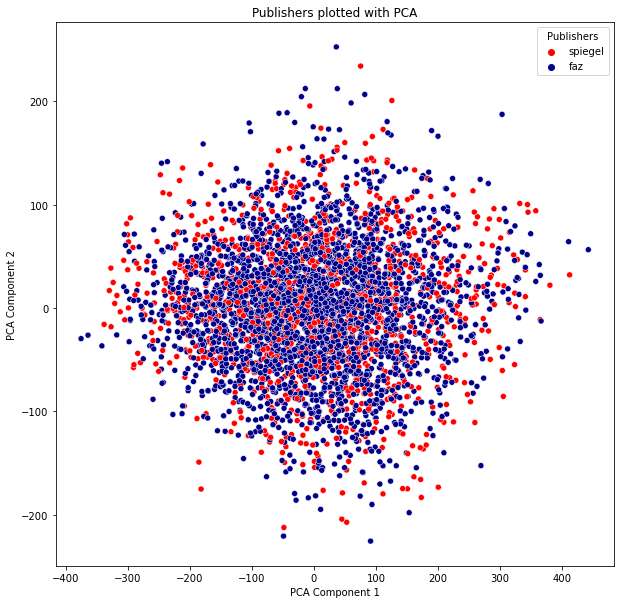

In [11]:
figsize(10, 10)

sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1],
                hue=y_train_df.replace({1: 'spiegel', 0:'faz'}), alpha=1,
                palette=['red', 'darkblue'])
xlabel("PCA Component 1")
ylabel("PCA Component 2")
title("Publishers plotted with PCA");

In [12]:
lr = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train_df)
lr.score(X_test_2PC, y_test)

0.6356513222331048

In [13]:
int_category_map = {1: 'spiegel', 0:'faz'}

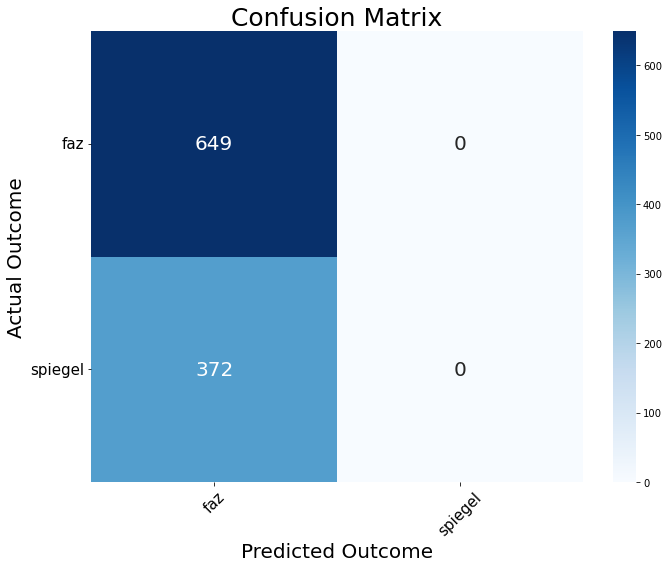

In [14]:
y_pred= lr.predict(X_test_2PC)

plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Images: Neural Net Baseline-Model**

In [15]:
# (X_train, X_test,y_train,y_test)
with open('image_data_array_fazsp.pickle','rb') as file:
    data = pickle.load(file)

In [16]:
X_train, X_test,X_val,y_train,y_test,y_val = data[0],data[1],data[2],data[3],data[4],data[5]

y_train_hotcode = keras.utils.to_categorical(y_train)
y_val_hotcode = keras.utils.to_categorical(y_val)
y_test_hotcode = keras.utils.to_categorical(y_test)

In [17]:
IMGgen = IMG.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)

In [18]:
train_ds = IMGgen.flow(X_train, y_train, batch_size=32)
val_ds = IMGgen.flow(X_val, y_val, batch_size=32)
test_ds = IMGgen.flow(X_test, y_test, batch_size=32)

In [20]:
if os.path.exists("cnn_model_fazsp.h5") == False:
    ### basic CNN model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=X_train.shape[1:]))

    cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(2, activation='sigmoid'))  # 2 target classes
     

    cnn.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        #loss ='categorical_crossentropy',
        #optimizer= keras.optimizers.Adam(learning_rate=0.01),
        #optimizer = optimizer,
        optimizer = 'Adam',
        metrics=['accuracy'],
    )
    cnn.summary()
    
    cnn_result = cnn.fit(train_ds,
             validation_data= val_ds,
             epochs=200, verbose=1, batch_size = 32,
             callbacks = tf.keras.callbacks.EarlyStopping(patience=5))  # track progress as we fit

    cnn.save("model_h5_file_fazsp/cnn_model_fazsp.h5")
    
    with open('cnn_result_fazsp.pickle','wb')as file:
        pickle.dump(cnn_result, file)

else: 
    cnn = keras.models.load_model('model_h5_file/cnn_model_fazsp.h5')
    
    with open('cnn_result_fazsp.pickle','rb') as file:
        cnn_result = pickle.load(file)

2022-08-01 19:47:23.121947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-01 19:47:23.122647: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 19:47:23.123898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fabian-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-01 19:47:23.134920: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

2022-08-01 20:03:28.788165: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d20b69b5-43ea-459b-a0ce-f68a7aba1189/assets


In [21]:
#Load checkpoint
cnn = load_model('model_h5_file_fazsp/cnn_model_fazsp.h5')

with open('cnn_result_fazsp.pickle','rb') as file:
        cnn_result = pickle.load(file)

In [22]:
y_pred= np.argmax(cnn.predict(X_test),axis =1)
print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

2022-08-01 20:04:28.737884: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 275670000 exceeds 10% of free system memory.


accuracy : 0.5768854064642507
recall : 0.5943241877495569
precision : 0.5879077398185678
f1 : 0.5728695382708398


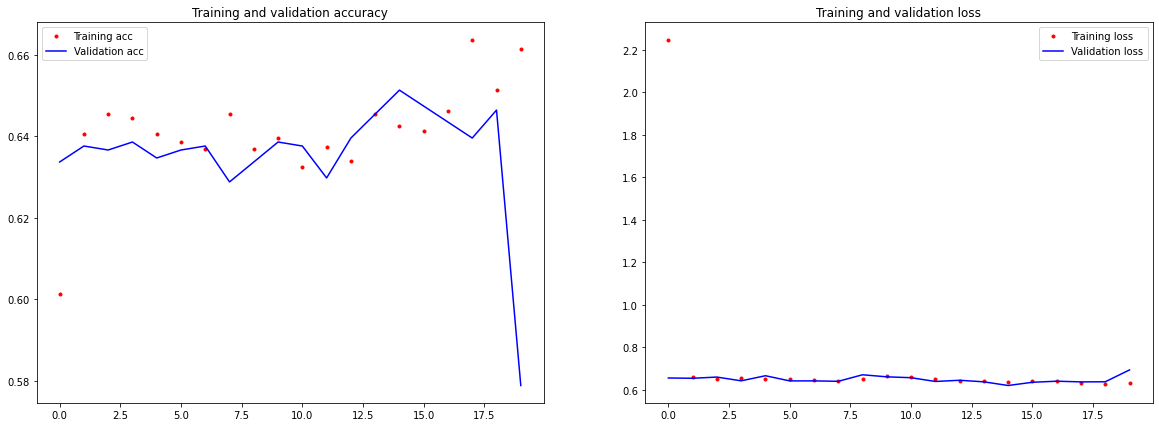

In [27]:
acc = cnn_result.history['accuracy']
val_acc = cnn_result.history['val_accuracy']
loss = cnn_result.history['loss']
val_loss = cnn_result.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot(epochs, acc, 'r.', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].title.set_text('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'r.', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].title.set_text('Training and validation loss')
ax[1].legend();

In [28]:
category_int_map = {'spiegel': 1, 'faz': 0}
int_category_map = {1: 'spiegel', 0:'faz'}

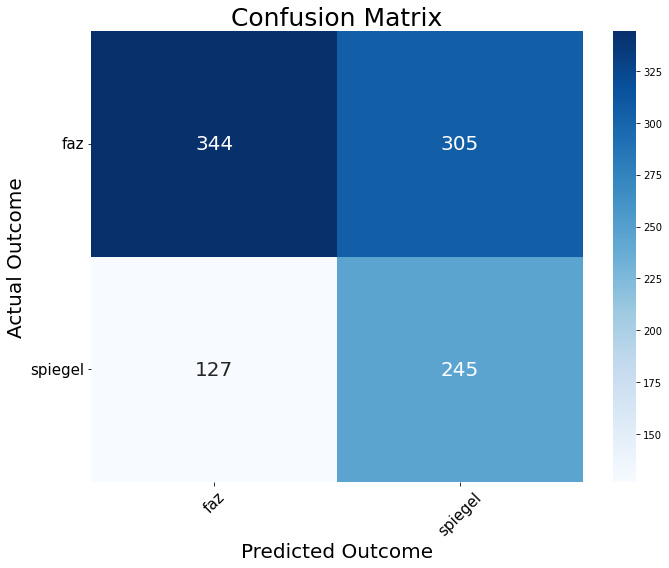

In [29]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

## Dataset C - Publishers FAZ (mid-right) and Zeit (mid-left) (Binary classification)

In [71]:
df_text = pd.read_csv('df_text.csv').drop('Unnamed: 0', axis=1)
df_text.dropna(inplace=True)
df_text['teaser'] = df_text.teaser.str.lower()
df_text.reset_index(drop=True, inplace=True)

In [72]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   teaser     4409 non-null   object
 1   publisher  4409 non-null   object
dtypes: object(2)
memory usage: 69.0+ KB


In [73]:
data = df_text['teaser'].map(word_tokenize).values
total_vocabulary = set(word.lower() for teaser in data for word in teaser) 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique teaser texts in the dataset.'.format(len(data)))

There are 16367 unique words in the dataset.
There are 4409 unique teaser texts in the dataset.


**Text: Non-Neural Net Baseline-Model**

In [74]:
nltk.download('stopwords')
list_sw = stopwords.words("german")
additional_sw = ['sagt', 'sei', 'seit', 'im', 'zwei', 'gibt', 'muss', 'tag', 'ganz', 'etwa', 'konnt', 'wurd', 'seien', 'beim', 'imm', 'erst', 'ganz', 'hatt', 'word', 'eig', 'bei', 'jahr', 'mehr', 'zahl', 'gut', 'mal', 'dafur', 'macht', 'mal', 'moglich', 'schon', 'hoh', 'dabei', 'geht', 'rund', 'drei', 'vier', 'fünf', 'sechs', 'sieben', 'acht', 'neun', 'zehn', 'million', 'milliard']

stopwords_added = list_sw + additional_sw

[nltk_data] Downloading package stopwords to /home/fabian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
# https://data-dive.com/german-nlp-binary-text-classification-of-reviews-part1

nltk.download('punkt')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords_added)


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    
    words_filtered_refined = [word for word in words_filtered if word not in stop_words]
        
    text_clean = " ".join(words_filtered_refined)
    return text_clean

[nltk_data] Downloading package punkt to /home/fabian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [76]:
corpus = df_text['teaser'].apply(lambda x: clean_text(x))
corpus

0       selenskyj skeptisch angesicht geplant verhandl...
1       spd glaubt ausreich gerhard schrod distanziert...
2       dauernd hiess china grosst herausforder amerik...
3       krieg ukrain folg wladimir putin machterhalt r...
4       russisch uberfall zeigt gas projekt zukunft sc...
                              ...                        
4404    ns opf sexuell geschlecht identitat ermordet s...
4405    steigend miet energiepreis mensch hilf staat b...
4406    fahr mahmaschin rehkitz fast unsichtbar meist ...
4407    erdoğan geschafft ukrain russland korridor wei...
4408    ukrain russland vereinbar wiederaufnahm getrei...
Name: teaser, Length: 4409, dtype: object

In [77]:
# Word Frequency of most common words
word_freq = pd.Series(" ".join(corpus).split()).value_counts()
word_freq[1:40].rename("Word frequency of most common words in articles").hvplot.bar(
    rot=45
).opts(width=700, height=400, yformatter=NumeralTickFormatter(format="0,0"))

:Bars   [index]   (Word frequency of most common words in articles)

In [78]:
# ngram_range=(1,2)
tv = TfidfVectorizer(min_df=.01, max_df=0.7, ngram_range=(1,2))
X_tv = tv.fit_transform(corpus)

In [79]:
dtm_tv = pd.DataFrame(X_tv.toarray(), columns=tv.get_feature_names())

/media/fabian/VM_space/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [80]:
y = df_text['publisher'].map({'faz':0, 'zeit':1})

In [81]:
X_train, X_test, y_train, y_test = train_test_split(dtm_tv, y, test_size=0.2)

In [82]:
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train)
X_test_2PC = pca.transform(X_test)

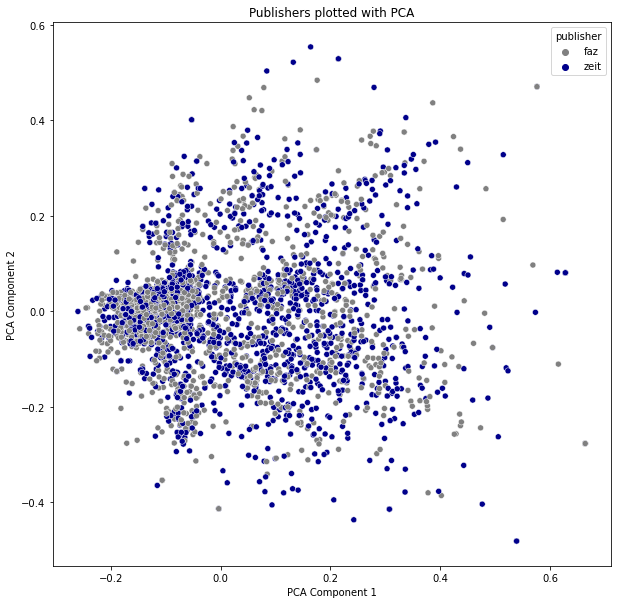

In [83]:
figsize(10, 10)

sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1],
                hue=y_train.replace({1: 'zeit', 0:'faz'}), alpha=1,
                palette=['grey', 'darkblue'])
xlabel("PCA Component 1")
ylabel("PCA Component 2")
title("Publishers plotted with PCA");

In [84]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train)
lr.score(X_test_2PC, y_test)

0.5532879818594104

In [85]:
int_category_map = {1: 'zeit', 0:'faz'}

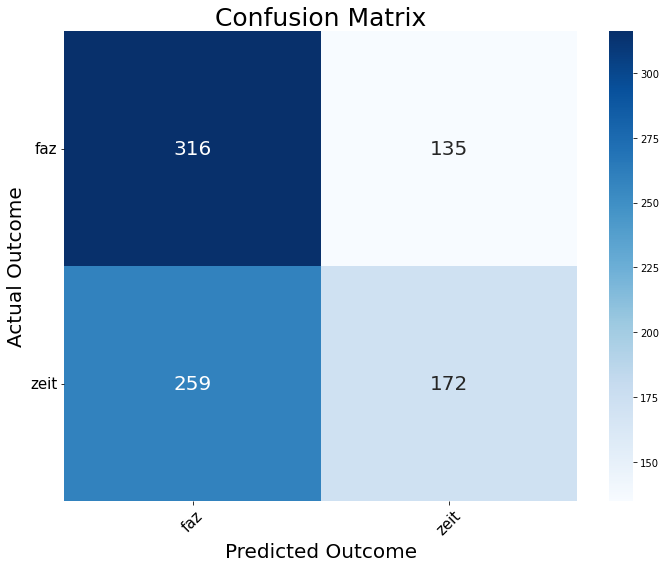

In [86]:
y_pred= lr.predict(X_test_2PC)

plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

**Text: Neural Net Baseline-Model**

In [125]:
target = df_text['publisher']
y = pd.get_dummies(target).values

tokenizer = Tokenizer(filters="""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',""", num_words=1000) 

tokenizer.fit_on_texts(list(df_text['teaser']))

In [126]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [127]:
tokenized_texts = tokenizer.texts_to_sequences(df_text['teaser'])
X = sequence.pad_sequences(tokenized_texts, maxlen=50)

In [128]:
indices = np.arange(len(X))

In [129]:
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, indices, test_size=0.2)

In [130]:
### Save X_digit, y_digit
text_data_array_fazzeit = (X_train, X_test,y_train,y_test,ind_train,ind_test)
with open('text_data_array_fazzeit.pickle','wb') as file:
    pickle.dump(text_data_array_fazzeit,file)

In [134]:
# create my NN model
lstm_model = Sequential()

embedding_size = 32
lstm_model.add(Embedding(len(total_vocabulary), embedding_size))
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dropout(0.8))
# lstm_model.add(Dense(50, activation='relu'))
# lstm_model.add(Dropout(0.7))
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dropout(0.8))
lstm_model.add(Dense(2, activation='sigmoid'))

In [135]:
lstm_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
lstm_model.summary() # check the shape

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 32)          523744    
                                                                 
 lstm_16 (LSTM)              (None, None, 32)          8320      
                                                                 
 global_max_pooling1d_16 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 25)                825       
                                                                 
 dropout_37 (Dropout)        (None, 25)                0         
                                                     

In [136]:
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.15)

Epoch 1/10
94/94 [==============================] - 6s 35ms/step - loss: 0.6935 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5415
Epoch 2/10
94/94 [==============================] - 3s 30ms/step - loss: 0.6938 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.5358
Epoch 3/10
94/94 [==============================] - 3s 30ms/step - loss: 0.6930 - accuracy: 0.5148 - val_loss: 0.6929 - val_accuracy: 0.5226
Epoch 4/10
94/94 [==============================] - 3s 30ms/step - loss: 0.6936 - accuracy: 0.5015 - val_loss: 0.6928 - val_accuracy: 0.5849
Epoch 5/10
94/94 [==============================] - 3s 30ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6924 - val_accuracy: 0.5792
Epoch 6/10
94/94 [==============================] - 3s 31ms/step - loss: 0.6920 - accuracy: 0.5239 - val_loss: 0.6906 - val_accuracy: 0.5679
Epoch 7/10
94/94 [==============================] - 3s 31ms/step - loss: 0.6822 - accuracy: 0.5649 - val_loss: 0.6596 - val_accuracy: 0.6283
Epoch 8/10
94

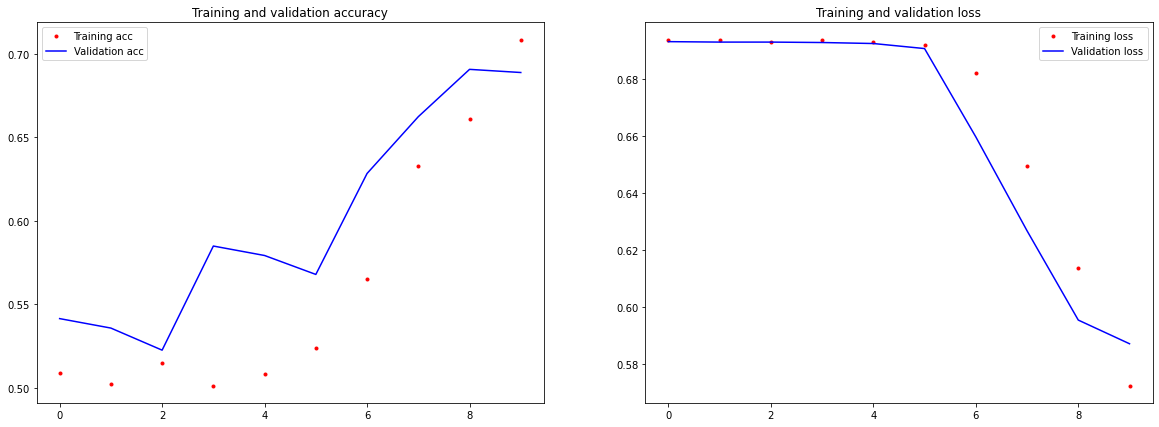

In [137]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot(epochs, acc, 'r.', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].title.set_text('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'r.', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].title.set_text('Training and validation loss')
ax[1].legend();

In [138]:
y_pred = keras.utils.to_categorical(np.argmax(lstm_model.predict(X_test),axis =1))
y_test

print("accuracy :",accuracy_score(y_test, y_pred))
print('recall :',recall_score(y_test,y_pred,average = 'macro'))
print('precision :', precision_score(y_test,y_pred,average = 'macro'))
print('f1 :', f1_score(y_test,y_pred,average = 'macro'))

accuracy : 0.6882086167800453
recall : 0.6870243139836261
precision : 0.6959007783673139
f1 : 0.6842302599974223


In [139]:
category_int_map = {'zeit': 1, 'faz': 0}
int_category_map = {1: 'zeit', 0:'faz'}

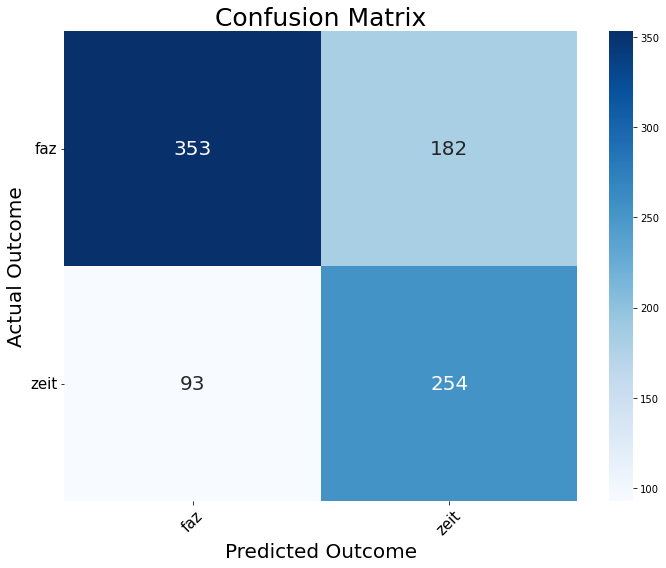

In [140]:
y_test_flat = np.select([y_test[:, 0] == 0, y_test[:, 0] == 1], [1, 0], y_test[:, 0])
y_pred = np.argmax(lstm_model.predict(X_test),axis =1)

plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion_matrix(y_pred, y_test_flat),
            annot = True, annot_kws={"size":20}, fmt="d",cmap = "Blues")

plt.title('Confusion Matrix', size=25)
plt.xlabel('Predicted Outcome', size=20)
plt.ylabel('Actual Outcome', size=20)
labels = [ int_category_map.get(key) for key in sorted(int_category_map.keys())]
ax.set_xticklabels(labels, size=15,rotation = 45)
ax.set_yticklabels(labels, size=15,rotation = 0)
plt.tight_layout()
plt.show();

In [141]:
lstm_model.save("models_text_fazzeit/basic_lstm_model_fazzeit.h5")

with open('basic_lstm_model_fazzeit.pickle','wb')as file:
    pickle.dump(history, file)

INFO:tensorflow:Assets written to: ram://8418bb20-e0cf-41d7-a85b-c00e08f2f937/assets


INFO:tensorflow:Assets written to: ram://8418bb20-e0cf-41d7-a85b-c00e08f2f937/assets


In [142]:
df_text

teaser publisher
0     selenskyj skeptisch angesichts geplanter verha...       faz
1     die spd glaubt, sich ausreichend von gerhard s...       faz
2     dauernd hieß es, china sei die größte herausfo...       faz
3     der krieg in der ukraine wird zur folge haben,...       faz
4     der russische überfall zeigt: das gas-projekt ...       faz
...                                                 ...       ...
4404  ns-opfer, die wegen ihrer sexuellen und geschl...      zeit
4405  wegen steigender mieten und energiepreise soll...      zeit
4406  für die fahrer von mähmaschinen sind rehkitze ...      zeit
4407  erdoğan hat es geschafft: die ukraine und russ...      zeit
4408  die ukraine und russland haben eine vereinbaru...      zeit

[4409 rows x 2 columns]